
[Nuvem] Inicializada...

[Nuvem] Verificando modelo inicial...

[Nuvem] Nenhum modelo inicial salvo encontrado. Inicializando com valores padrões...

[Nuvem] Conectando aos servidores...
[Nuvem] Conectado ao Servidor 1!
[Nuvem] Enviando modelo global inicial para o servidor 1...
[Nuvem] Modelo global inicial enviado para o servidor 1 com sucesso!
[Nuvem] Conectado ao Servidor 2!
[Nuvem] Enviando modelo global inicial para o servidor 2...
[Nuvem] Modelo global inicial enviado para o servidor 2 com sucesso!
[Nuvem] Conectado ao Servidor 3!
[Nuvem] Enviando modelo global inicial para o servidor 3...
[Nuvem] Modelo global inicial enviado para o servidor 3 com sucesso!

[Nuvem] Iniciando rodada 1 de aprendizado federado
[Nuvem] Aguardando conexão dos servidores...
[Nuvem] Servidor 1 conectado: ('127.0.0.1', 65260)!
[Nuvem] Modelo intermediário recebido do Servidor 1!
[Nuvem] Servidor 2 conectado: ('127.0.0.1', 61441)!
[Nuvem] Modelo intermediário recebido do Servidor 2!
[Nuvem] Servidor 3 

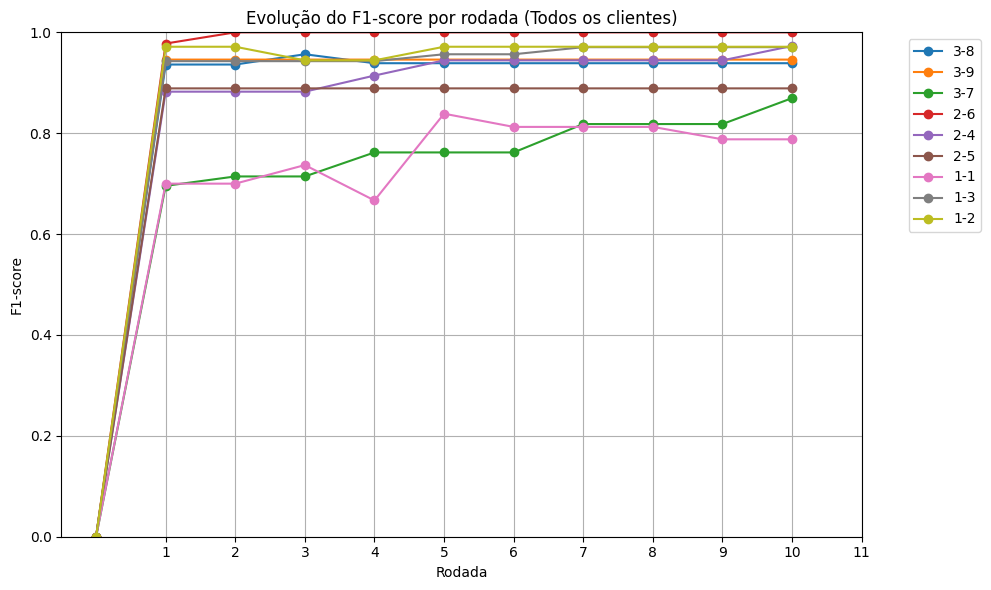

In [1]:
import socket
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

# Constantes de configuração
HOSPITAL_HOST = 'localhost'
HOSPITAL_PORT_SEND = 6001  # Porta para enviar modelo global
HOSPITAL_PORT_RECV = 6000  # Porta para receber modelos dos hospitais

NUM_HOSPITALS = 3 # Quantidade de servidores de hopsitais esperados
NUM_ROUNDS = 10 # Quantidade de rodadas de treinamento federado

# Função para receber os parâmetros do modelo intermediário de um servidor de hospital via Json
def receive_hospital_parameters(conn):
    data = b""
    while True:
        packet = conn.recv(HOSPITAL_PORT_RECV)
        if not packet:
            break
        data += packet

    decoded = json.loads(data.decode('utf-8'))

    coef = np.array(decoded['coef'])
    intercept = np.array(decoded['intercept'])
    data_size = int(decoded['data_size'])

    return coef, intercept, data_size

# Inicializar o modelo global
global_model = SGDClassifier(
    loss='hinge',           # Função de perda "hinge", que implementa o classificador linear de margem máxima usado no SVM
    penalty='elasticnet',   # Penalização Elastic Net: combinação de L1 (sparsidade) e L2 (regularização de peso)
    l1_ratio=0.05,          # Proporção do L1 na penalização Elastic Net (0 = só L2, 1 = só L1); 
    max_iter=1,             # Número máximo de épocas (passadas pelos dados) por chamada ao fit/partial_fit; 
    learning_rate='optimal',# Estratégia de taxa de aprendizado: 'optimal' usa uma taxa adaptativa baseada no número de iterações
    eta0=0.005,             # Taxa de aprendizado inicial (usada se o learning_rate permitir, aqui influencia o cálculo adaptativo)
    alpha=1e-3,             # Fator de regularização global (quanto maior, mais forte a regularização e menos ajuste aos dados)
    average=True,           # Faz média dos coeficientes ao longo das iterações, geralmente melhora estabilidade e generalização
    random_state=42         # Semente para reprodutibilidade dos resultados
)

global_coef = None
global_intercept = None

# Enviar modelo inicial aos servidores dos hospitais
print("\n[Nuvem] Inicializada...")

print("\n[Nuvem] Verificando modelo inicial...")

MODEL_FILE = 'Modelo_Federado_SVM.json'

if os.path.exists(MODEL_FILE):
    print("\n[Nuvem] Carregando modelo inicial de arquivo existente...")
    with open(MODEL_FILE, 'r') as f:
        model_data = json.load(f)
        initial_coef = np.array(model_data['coef'])
        initial_intercept = np.array(model_data['intercept'])
else:
    print("\n[Nuvem] Nenhum modelo inicial salvo encontrado. Inicializando com valores padrões...")
    # Dados fictícios para inicializar pesos
    X_fake = np.zeros((1, 5))      # Exemplo: 5 features
    y_fake = np.zeros(1)           # Intercepto inicial fixo

    # Chamada inicial para criar pesos e estruturas internas
    global_model.partial_fit(X_fake, y_fake, classes=[0, 1])
    initial_coef = global_model.coef_
    initial_intercept = global_model.intercept_

initial_model_data = {
    "coef": initial_coef.tolist(),
    "intercept": initial_intercept.tolist(),
    "num_rounds" : int(NUM_ROUNDS),
    "params": {
        "loss": global_model.loss,
        "penalty": global_model.penalty,
        "l1_ratio": global_model.l1_ratio, 
        "max_iter": global_model.max_iter,
        "learning_rate": global_model.learning_rate,
        "eta0": global_model.eta0,
        "alpha": global_model.alpha,
        "average": global_model.average,
        "random_state": global_model.random_state
    }
}

data = json.dumps(initial_model_data).encode('utf-8')

print("\n[Nuvem] Conectando aos servidores...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((HOSPITAL_HOST, HOSPITAL_PORT_SEND))
    s.listen(NUM_HOSPITALS)

    for i in range(NUM_HOSPITALS):
        conn, addr = s.accept()
        with conn:
            print(f"[Nuvem] Conectado ao Servidor {i+1}!")
            print(f"[Nuvem] Enviando modelo global inicial para o servidor {i+1}...")
            conn.sendall(data)
            print(f"[Nuvem] Modelo global inicial enviado para o servidor {i+1} com sucesso!")

# Ciclo principal de treinamento federado
for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n[Nuvem] Iniciando rodada {round_num} de aprendizado federado")

    hospital_weights = []
    hospital_sizes = []

    # Receber modelo intermediário dos servidores dos hospitais
    print(f"[Nuvem] Aguardando conexão dos servidores...")
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOSPITAL_HOST, HOSPITAL_PORT_RECV))
        s.listen(NUM_HOSPITALS)

        for i in range(NUM_HOSPITALS):
            conn, addr = s.accept()
            with conn:
                print(f"[Nuvem] Servidor {i+1} conectado: {addr}!")
                hospital_coef, hospital_intercept, data_size = receive_hospital_parameters(conn)

                if not (isinstance(hospital_coef, np.ndarray) and isinstance(hospital_intercept, np.ndarray) and isinstance(data_size, int)):
                    raise ValueError("Dados recebidos do Servidor estão em formato incorreto.")

                hospital_weights.append((hospital_coef, hospital_intercept))
                hospital_sizes.append(data_size)

                print(f"[Nuvem] Modelo intermediário recebido do Servidor {i+1}!")

    # Inicializa os acumuladores se for a primeira rodada
    if global_coef is None:
        global_coef = np.zeros_like(hospital_weights[0][0])
        global_intercept = np.zeros_like(hospital_weights[0][1])
    else:
        global_coef.fill(0)
        global_intercept.fill(0)

    total_data_size = sum(hospital_sizes)
    if total_data_size == 0:
        raise ValueError("Tamanho total dos dados dos Servidores é zero.")

    # Realização do FedAvg(Agregação por média)
    # Coef e Intercept são os parâmetros utilizados pela regressão logística
    # - Coef(Coeficiente): Representa os pesos atribuídos a cada atributo (feature) do modelo. É um vetor ou matriz (dependendo da tarefa) que determina quanto cada variável influencia a predição.
    # - Intercept(Intercepto): É o termo de bias, o valor que o modelo usa quando todas as entradas são zero. Serve para ajustar o ponto de corte (threshold) da função de decisão.
    print(f"[Nuvem] Realizando FedAvg do modelo global...")
    for i in range(NUM_HOSPITALS):
        weight = hospital_sizes[i] / total_data_size         # Calcular o peso (importância) do servidor na agregação
        global_coef += hospital_weights[i][0] * weight       # Coeficientes ponderados
        global_intercept += hospital_weights[i][1] * weight  # Intercepto ponderado

    # Atualizar modelo global
    global_model.coef_ = global_coef
    global_model.intercept_ = global_intercept

    print(f"[Nuvem] Modelo global atualizado na rodada {round_num}!")

    # Enviar modelo global para os servidores dos hospitais
    print(f"[Nuvem] Enviando modelo global para os servidores...")
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOSPITAL_HOST, HOSPITAL_PORT_SEND))
        s.listen(NUM_HOSPITALS)

        for i in range(NUM_HOSPITALS):
            conn, addr = s.accept()
            with conn:
                print(f"[Nuvem] servidor {i+1} conectado: {addr}!")
                global_model_data = {
                    "coef": global_model.coef_.tolist(),
                    "intercept": global_model.intercept_.tolist()
                }
                data = json.dumps(global_model_data).encode('utf-8')
                print(f"[Nuvem] Enviando modelo global para o servidor {i+1}...")
                conn.sendall(data)
                print(f"[Nuvem] Modelo global enviado para o servidor {i+1}!")

print("\n[Nuvem] Todas as rodadas de treinamento federado foram concluídas!")

# Salvar modelo global final em arquivo JSON
print(f"\n[Nuvem] Salvando modelo global final...")
final_model_data = {
    "class": global_model.__class__.__name__,
    "params": global_model.get_params(),
    "coef": global_model.coef_.tolist(),
    "intercept": global_model.intercept_.tolist()
}
with open(MODEL_FILE, 'w') as f:
    json.dump(final_model_data, f)
print(f"[Nuvem] Modelo global salvo em '{MODEL_FILE}'.")

# Receber f1 dos servidores dos hospitais
all_f1_servers = {}  # dicionário para armazenar F1 por cliente
print(f"\n[Nuvem] Aguardando conexão dos servidores...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOSPITAL_HOST, HOSPITAL_PORT_RECV))
    s.listen(NUM_HOSPITALS)

    for i in range(NUM_HOSPITALS):
        conn, addr = s.accept()
        with conn:
            print(f"[Nuvem] Servidor {i+1} conectado: {addr}!")
            
            # Recebe os dados
            data = b""
            while True:
                packet = conn.recv(4096)  # buffer
                if not packet:
                    break
                data += packet

            # Desserializa o JSON
            received = json.loads(data.decode("utf-8"))
            server_id = received["id"]
            f1_per_round = received["f1"]

            # Salva no dicionário principal
            all_f1_servers[server_id] = f1_per_round

        print(f"[Nuvem] Recebido F1 dos clientes do Servidor {i+1} com sucesso!")

# Recebendo métricas de desempenho dos modelos intermediários dos servidores dos hospitais
final_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

# Receber métricas do modelo intermediário dos servidores dos hospitais
print(f"\n[Nuvem] Aguardando conexão dos servidores...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOSPITAL_HOST, HOSPITAL_PORT_RECV))
    s.listen(NUM_HOSPITALS)

    for i in range(NUM_HOSPITALS):
        conn, addr = s.accept()
        with conn:
            print(f"[Nuvem] Servidor {i+1} conectado: {addr}!")
            data = conn.recv(HOSPITAL_PORT_RECV)
            metrics = json.loads(data.decode('utf-8'))
            for key in final_metrics:
                final_metrics[key].append(metrics[key])
print(f"[Nuvem] Métricas do modelo intermediário recebidas do Servidor {i+1} com sucesso!")

# Média final global
print(f"\n[Nuvem] Realizando média final global das métricas de desempenho do modelo...")
global_avg = {k: np.mean(v) for k, v in final_metrics.items()}

# Exibindo as métricas de desempenho do modelo global final
print("[Nuvem] Avaliação Global final do Modelo Federado:")
for metric, value in global_avg.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Exibindo gráfico da evolução do f1 de cada cliente
plt.figure(figsize=(10,6))

for server_id, f1_dict in all_f1_servers.items():
    for client_id, f1_list in f1_dict.items():
        # Converte string para lista se necessário
        if isinstance(f1_list, str):
            import ast
            f1_list = ast.literal_eval(f1_list)
        plt.plot(range(len(f1_list)), f1_list, marker='o', label=f"{server_id}-{client_id}")

plt.xlabel("Rodada")
plt.ylabel("F1-score")
plt.title("Evolução do F1-score por rodada (Todos os clientes)")
plt.xticks(range(1, len(f1_list)+1))
plt.ylim(0,1)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()